## 1. Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Read Datasets

Read Train Images and Labels

In [5]:
train_data = pd.read_csv('datasets/emnist-bymerge-train.csv',nrows=1000)
train_images = train_data.iloc[:,1:].values.reshape(-1,28,28).astype('float32')/255
train_images = torch.tensor(train_images).unsqueeze(1)
train_images = torch.nn.functional.interpolate(train_images,size=(224,224))

train_labels = train_data.iloc[:,0].values.astype('int')

## 3. Convert to RGB, Normalized with Mean and Std, and Prepare Data Loaders

Convert to RGB

In [30]:
train_images_rgb = train_images.repeat(1,3,1,1)

Normalized with Mean and Std

In [32]:
mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
std = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)

train_images_normalized = (train_images_rgb - mean)/std

Prepare Data Loaders

In [34]:
train_tensor_labels = torch.tensor(train_labels,dtype=torch.long)
train_tensor_dataset = TensorDataset(train_images_normalized,train_tensor_labels)
train_data_loader = DataLoader(train_tensor_dataset,batch_size=64,shuffle=True)

## 4. Classification using CNN and Evaluation using LOOCV

Initialize Variables

In [36]:
all_preds = []
all_true = []

Classification and Evaluation

In [26]:
num_data = min(100,len(train_images_normalized))
for i in range(num_data):
    print(f"LOOCV Iteration {i+1}/{num_data}")

    test_cv_images = train_images_normalized[i:i+1]
    test_cv_labels = train_tensor_labels[i:i+1]
    train_cv_images = torch.cat((train_images_normalized[:i],train_images_normalized[i+1:]))
    train_cv_labels = torch.cat((train_tensor_labels[:i],train_tensor_labels[i+1:]))

    train_cv_dataset = TensorDataset(train_cv_images,train_cv_labels)
    train_cv_loader = DataLoader(train_cv_dataset,batch_size=16,shuffle=True)
    
    model = models.alexnet(weights='IMAGENET1K_V1')
    num_classes = len(torch.unique(train_tensor_labels))  # Automatically detect the number of classes
    model.classifier[6] = nn.Linear(4096, num_classes)
    model.to(torch.device('cpu'))

    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=0.0001)

    model.train()
    for epoch in range(3):
        running_loss = 0.0
        correct_predictions = 0
        for inputs, labels in train_cv_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(test_cv_images)
        pred = outputs.argmax(dim=1)
        all_preds.extend(pred.numpy())
        all_true.extend(test_cv_labels.numpy())

mean_accuracy = accuracy_score(all_true,all_preds)
mean_precision = precision_score(all_true,all_preds,average='weighted',zero_division=0)
mean_f1_score = f1_score(all_true,all_preds,average='weighted')
conf_matrix = confusion_matrix(all_true,all_preds,labels=range(num_classes))

print(f"{mean_accuracy:.4f}")
print(f"{mean_precision:.4f}")
print(f"{mean_f1_score:.4f}")
print(conf_matrix)

LOOCV Iteration 1/100
LOOCV Iteration 2/100
LOOCV Iteration 3/100
LOOCV Iteration 4/100
LOOCV Iteration 5/100
LOOCV Iteration 6/100
LOOCV Iteration 7/100
LOOCV Iteration 8/100
LOOCV Iteration 9/100
LOOCV Iteration 10/100
LOOCV Iteration 11/100
LOOCV Iteration 12/100
LOOCV Iteration 13/100
LOOCV Iteration 14/100
LOOCV Iteration 15/100
LOOCV Iteration 16/100
LOOCV Iteration 17/100
LOOCV Iteration 18/100
LOOCV Iteration 19/100
LOOCV Iteration 20/100
LOOCV Iteration 21/100
LOOCV Iteration 22/100
LOOCV Iteration 23/100
LOOCV Iteration 24/100
LOOCV Iteration 25/100
LOOCV Iteration 26/100
LOOCV Iteration 27/100
LOOCV Iteration 28/100
LOOCV Iteration 29/100
LOOCV Iteration 30/100
LOOCV Iteration 31/100
LOOCV Iteration 32/100
LOOCV Iteration 33/100
LOOCV Iteration 34/100
LOOCV Iteration 35/100
LOOCV Iteration 36/100
LOOCV Iteration 37/100
LOOCV Iteration 38/100
LOOCV Iteration 39/100
LOOCV Iteration 40/100
LOOCV Iteration 41/100
LOOCV Iteration 42/100
LOOCV Iteration 43/100
LOOCV Iteration 44/1

## 5. Plot Confusion Matrix

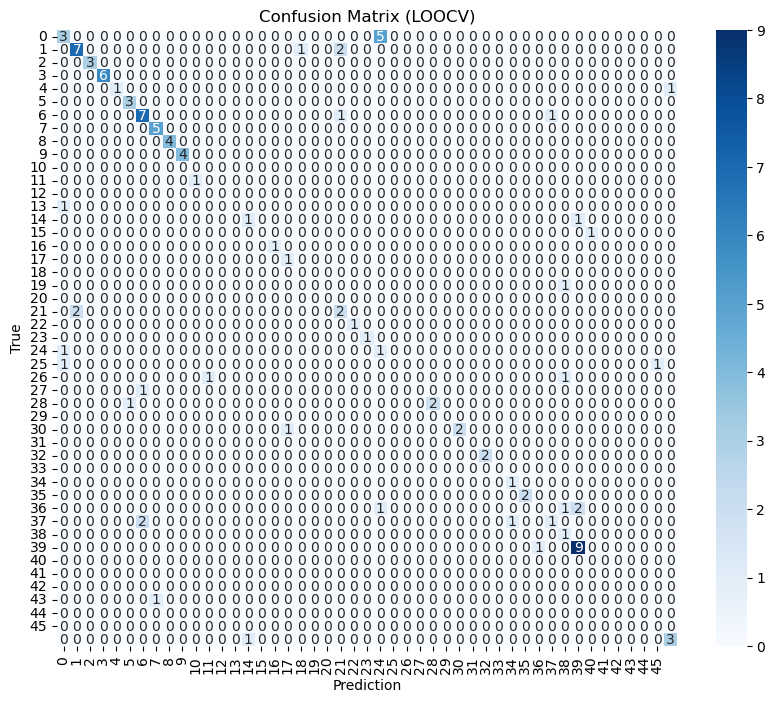

In [27]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=range(46),yticklabels=range(46))
plt.title("Confusion Matrix (LOOCV)")
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()